## Joke classificaion with logistic regression, a multilayer perceptron and a convolutional neural network.

For the task of joke detection, I trained three different classifiers using different models:

1. [Logistic Regression](#log_model)
2. [Feed Forward Neural Network](#mlp_model)
3. [Convoluational Neural Network](#convnet)

[After training, the models will be tested on known and unknown datasets.](#testing)

In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

import xgboost, numpy, textblob, string
import pandas as pd
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import prejokes

/Users/miriamamin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/te

### Dataset preparation

The Dataset produced in the previous step does not have the required form yet. it currently looks like this:

In [2]:
infile = '../data/joke_classifier_dataset.csv'
joke_df = pd.read_csv(infile, index_col=0)
joke_df.head()

,joke,nonjoke
0,A blonde is walking down the street with her ...,"Finally, Sue walks down Hollywood Boulevard, a..."
1,"A blonde, a brunette and a redhead were walki...","The two women kiss, before Nikki fades away in..."
2,There was a blonde woman who was having finan...,Basil then reveals that he can't go on the hei...
3,This blonde had a near death experience the o...,"In one instance, she woke up screaming and her..."
4,"Two blondes are walking down a road, one has ...",The two steal a car (a 1996 Impala SS sedan) a...


For training the classifier, I need a dataframe with the two columns `target` and `label`. The label indicated wheather a text is a joke or not. 

`1` means joke and `0`means no joke

In [4]:
pj = prejokes.JokePreprocessor()
jokes = joke_df.copy()
jokes.drop('nonjoke',axis=1, inplace=True)
jokes = pj.add_labels(jokes, 1)
nojokes = joke_df.copy()
nojokes.drop('joke',axis=1, inplace=True)
nojokes = pj.add_labels(nojokes, 0)
dataset = pj.merge_and_shuffle([jokes,nojokes])
dataset.to_csv('../data/joke_nonjoke_dataset.csv')
dataset.head(10)


,text,label
606,"""Michael Vick shouldn't go to jail for dog fi...",1
299,Joseph Crone wakes in his hotel room on Novemb...,0
209,A man and a friend are playing golf one day a...,1
130,"Whip, unable to bring himself to blame Trina f...",0
327,Three ants went to the beach to swim.\nTwo ju...,1
965,"David has also been praying to the ""God of gre...",0
728,"The team, including the coach, are against it,...",0
352,You have more than three first names.\n \nYou...,1
34,A mother took her little boy to church. \nWhi...,1
334,"A blonde walked into the pet store and, after...",1


The dataset now has the following dimensions:

In [5]:
print(dataset.shape)


(2216, 2)


### Logistic regression

<a id='log_model'></a>

For training, I split the entire joke dataset into test and training datasets 

In [6]:
sentences = dataset['text'].values
y = dataset['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

The feature vectors for the model are created by vectorizing the tokens with CountVectorizer.
CountVectorizer replaces the document by a vocabulary-sized vector where each value of the vector represents the frequency of the respective vocabulary item in the document.
Punctuation and other special characters are removed. 

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

After feature engineering, the model is fit on the data. 

In [25]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, y_train)
score = logistic_classifier.score(X_test, y_test)
print("Accuracy:", score)


Accuracy: 0.9927797833935018


The classifier yields a mean accuracy of 99.2 % on the given test data and labels.

### Multilayer Perceptron  Model <a id='mlp_model'></a>
The second model is a simple feedforward multilayer perceptron with. It consists of two densely conntected neural network layers. This model reuses the count-vectorized dataset from the logistic model.

In [12]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

seq_model = Sequential()
seq_model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
seq_model.add(layers.Dense(1, activation='sigmoid'))

seq_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                117950    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 117,961
Trainable params: 117,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = seq_model.fit(X_train, y_train,epochs=5,verbose=False,validation_data=(X_test, y_test),batch_size=10)

In [19]:
loss, accuracy = seq_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = seq_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9892


In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

After training the model for five epochs, training and validation accuracy are satisfactory. The validation loss curve implies that further training would lead to an increase and consequently to overfitting.

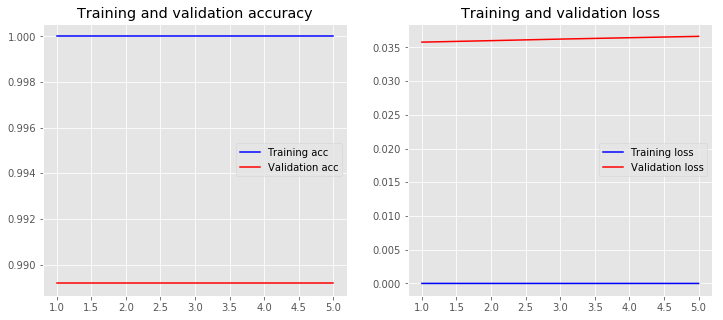

In [22]:
plot_history(history)

### Testing the Models <a id='testing'></a>

In [131]:
def lr_predict_joke(text, vectorizer, model):
    text=vectorizer.transform([text])
    prediction = model.predict(text)
    return prediction[0]

def mlp_predict_joke(text, vectorizer, model):
    text=vectorizer.transform([text])
    prediction = model.predict(text)
    output = 1 if prediction > 0.5 else 0
    return output

To understand the classifiers better, I have look at the mistakes the three classifiers prouduce on the training data.

In [133]:
predictions = pd.read_csv('../data/joke_nonjoke_dataset.csv', index_col=0)
predictions['logistic_regression'] = predictions['text'].apply(lambda x: lr_predict_joke(x, vectorizer, logistic_classifier))
predictions['multilayer_perceptron'] = predictions['text'].apply(lambda x: mlp_predict_joke(x, vectorizer, seq_model))

fails = predictions.loc[(predictions['label'] != predictions['logistic_regression']) | 
                        (predictions['label'] != predictions['multilayer_perceptron'])]

fails

,text,label,logistic_regression,multilayer_perceptron
901,eer booze and fun!' 'At the end of the night ...,1,0,0
898,Jack is told by the judge that releasing the i...,0,0,1
118,He is reunited with his family and all the peo...,0,0,1
271,1) A person belonging to an ethnic group whos...,1,0,0
388,Jack is told by the judge that releasing the i...,0,0,1
665,Attempting to enter a case-sensitive password...,1,0,0
864,"During the days in Vegas, they get to know eac...",0,1,0


Apparently, all three models produce the same mistake by classifxing the same documents incorrectly.
<br>
<br>
These are the jokes that were not recognized as jokes:

In [134]:
first_kind_mistakes = fails.loc[fails['label'] == 1]
for text in first_kind_mistakes['text']:
    print(text + '\n' + '-'*10)

 eer booze and fun!' 'At the end of the night a man leaves the bar. Outside he sees a nun. He walks over to her and slaps her in the face. Then he punches her in the stomach and knocks her over.  He proceeds to kick her several times and when he's done he bends down to her and says "not so tough tonight are you Batman?" 
----------
 1) A person belonging to an ethnic group whose members are commonly considered to have certain stereotypical mannerisms met another person belonging to a different ethnic group with a different set of imputed stereotypical mannerisms. The first person acted in a manner consistent
with the stereotypes associated with his ethnic group, and proceeded to make a remark which might be considered to establish conclusively his membership in that group, whereupon his companion proceeded to make a remark with a double meaning, the first meaning of which could be
interpreted to indicate his agreement with his companion, but the other meaning of which serves to corrobo

These jokes are indeed hardly recognizable as jokes, even for a human.
<br>
<br>
The follwing movie plot snippet was incorrectly classified as joke:

In [135]:
second_kind_mistakes = fails.loc[fails['label'] == 0]
for text in second_kind_mistakes['text']:
    print(text + '\n' + '-'*10)

Jack is told by the judge that releasing the identity of an adoptee's parents can cause suffering, as he points out that one adopted girl died three years earlier. Jack goes on to research the story of Joe Ottoman, who was in a car accident in 1945 that killed his wife, but his daughter survived. Joe worked for ten years on the Nativity carving. In 1963, Joe made the same mistake and was in a car accident again. His daughter Carmen Ana Ottoman, gave birth to a boy on December 24, 1963, but Carmen died two days later. Joe set his grandson up for adoption, then he disappeared from the presses and no one knew whether or not he was alive.
----------
He is reunited with his family and all the people who populate his memory. His father is happy to see him. He encounters his dead brother, whom he brings to his parents. The parents are then seen saying goodbye to the young brother as he steps out of a home into a vast expanse. Accompanied by a woman in white and a young woman, Mrs. O'Brien loo

To test the generalizability of the models, they will be first tested on the entire joke and non-joke data. The joke dataset and the non joke dataset will be tested seperately.

In [142]:
from prejokes import JokePreprocessor

jokes_file = '../data/s3_curated_jokes.csv'
jp = JokePreprocessor()
joke_df = jp.load(jokes_file)
joke_df.columns = ['text']
joke_df['label'] = 1
joke_df['sequential_model_prediction'] = joke_df['text'].apply(lambda x: mlp_predict_joke(x, vectorizer, seq_model))
joke_df['linear_regression_prediction'] = joke_df['text'].apply(lambda x: lr_predict_joke(x, vectorizer, logistic_classifier))
mlp_joke_fails = joke_df.loc[(joke_df['sequential_model_prediction'] == 0)]
linear_regression_joke_fails = joke_df.loc[(joke_df['linear_regression_prediction'] == 0)]
mlp_joke_accuracy = 1-(mlp_joke_fails.shape[0]/joke_df.shape[0])
lin_reg_accuracy = 1-(linear_regression_joke_fails.shape[0]/joke_df.shape[0])
print('Accuracy Linear Regression on Joke Dataset: ' + str(lin_reg_accuracy)) 
print('Accuracy Multilayer Perceptron on Joke Dataset: ' + str(mlp_joke_accuracy))

Accuracy Linear Regression on Joke Dataset: 0.976116047908398
Accuracy Multilayer Perceptron on Joke Dataset: 0.9863720979242036


In [145]:
movieplots_file = '../data/plotdata.txt'
with open(movieplots_file) as file:
    movieplots = file.read().strip().split('\n\n\n\n\n\n')
plot_df = pd.DataFrame(movieplots)
plot_df.columns = ['plot']
plot_df = jp.sentence_n_grams_split(plot_df, 'plot', 6)
plot_df.columns = ['text']
plot_df['label'] = 0
plot_df['sequential_model_prediction'] = plot_df['text'].apply(lambda x: mlp_predict_joke(x, vectorizer, seq_model))
plot_df['linear_regression_prediction'] = plot_df['text'].apply(lambda x: lr_predict_joke(x, vectorizer, logistic_classifier))
mlp_movieplot_fails = plot_df.loc[(plot_df['sequential_model_prediction'] == 1)]
linear_regression_movieplot_fails = plot_df.loc[(plot_df['linear_regression_prediction'] == 1)]
mlp_movieplot_accuracy = 1-(mlp_movieplot_fails.shape[0]/plot_df.shape[0])
lin_reg_movieplot_accuracy = 1-(linear_regression_movieplot_fails.shape[0]/plot_df.shape[0])
print('Accuracy Linear Regression on Movie Plot Dataset: ' + str(lin_reg_movieplot_accuracy)) 
print('Accuracy Multilayer Perceptron on Movie Plot Dataset: ' + str(mlp_movieplot_accuracy))

Accuracy Linear Regression on Movie Plot Dataset: 0.9890725243210502
Accuracy Multilayer Perceptron on Movie Plot Dataset: 0.9876756863666143


Additionally, both models are applied on two science fiction novels: Douglas Adams's The Hitchhiker's Guide to the Galaxy and Salman Rushdie's Satanic Verses.

In [147]:
 def load_book_to_df(file):
    with open(file, 'r') as textfile:
        text = textfile.read().replace('\n', ' ')
        #sentences = sent_tokenize(text)
    df = pd.DataFrame([text])
    df.columns = ['text']
    return df

Douglas Adams

In [153]:
from nltk.tokenize import sent_tokenize

adams = '../data/Adams_Hitchhikers_Guide.txt'
adams_df= load_book_to_df(adams)
six_grams = jp.sentence_n_grams_split(adams_df, 'text', 6)
six_grams['sequential_model_prediction'] = six_grams['joke_ngram'].apply(lambda x: mlp_predict_joke(x, vectorizer, seq_model))
six_grams['linear_regression_prediction'] = six_grams['joke_ngram'].apply(lambda x: lr_predict_joke(x, vectorizer, logistic_classifier))
mlp_jokes= six_grams.loc[(six_grams['sequential_model_prediction'] == 1)]
lr_jokes= six_grams.loc[(six_grams['linear_regression_prediction'] == 1)]
print('Anteil Humor am gesamten Text (MLP prediaction): ' + str(mlp_jokes.shape[0]/six_grams.shape[0]))
print('Anteil Humor am gesamten Text (LR prediction): ' + str(lr_jokes.shape[0]/six_grams.shape[0]))

Anteil Humor am gesamten Text (MLP prediaction): 0.9748189361600077
Anteil Humor am gesamten Text (LR prediction): 0.9407645450621133


Salman Rushdie

In [154]:
adams = '../data/RushdieSalman_TheSatanicVerses.txt'
adams_df= load_book_to_df(adams)
six_grams = jp.sentence_n_grams_split(adams_df, 'text', 6)
six_grams['sequential_model_prediction'] = six_grams['joke_ngram'].apply(lambda x: mlp_predict_joke(x, vectorizer, seq_model))
six_grams['linear_regression_prediction'] = six_grams['joke_ngram'].apply(lambda x: lr_predict_joke(x, vectorizer, logistic_classifier))
mlp_jokes= six_grams.loc[(six_grams['sequential_model_prediction'] == 1)]
lr_jokes= six_grams.loc[(six_grams['linear_regression_prediction'] == 1)]
print('Anteil Humor am gesamten Text (MLP prediction): ' + str(mlp_jokes.shape[0]/six_grams.shape[0]))
print('Anteil Humor am gesamten Text (LR prediction): ' + str(lr_jokes.shape[0]/six_grams.shape[0]))

Anteil Humor am gesamten Text (MLP prediction): 0.8935897435897436
Anteil Humor am gesamten Text (LR prediction): 0.7671245421245422
